This code takes an original DXF file and generates automatically the skin profile 

In [445]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import cufflinks
import ezdxf as dxf
from ezdxf import recover
from ezdxf.addons.drawing import RenderContext, Frontend
from ezdxf.addons.drawing.matplotlib import MatplotlibBackend
from ezdxf.groupby import groupby
import scipy.interpolate
import os.path
import math
pd.options.plotting.backend = "plotly"
%matplotlib notebook

In [446]:
original_dxf = r'C:\Users\Administrator\arduino ski scanner\ski scanner\skiScanner-DataLogger\Post processing\Ski-test3.dxf'
dxf_filename = r'C:\Users\Administrator\arduino ski scanner\ski scanner\skiScanner-DataLogger\Post processing\Skin-test2.dxf'
buckle = 8.5 #cm

Loading and plot the ski profile from dxf generated by scanner data

<IPython.core.display.Javascript object>


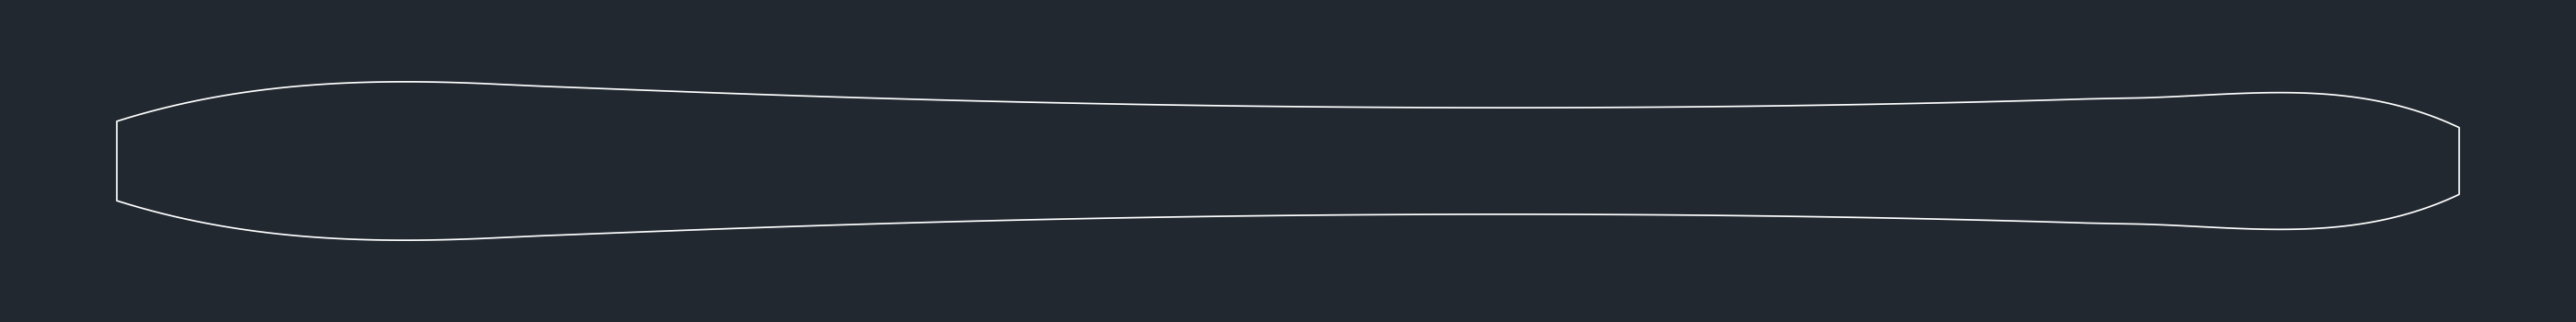

In [447]:
# Safe loading procedure of dxf file(requires ezdxf v0.14):
# The auditor.errors attribute stores severe errors,
# which may raise exceptions when rendering.

try:
    doc, auditor = recover.readfile(original_dxf)
except IOError:
    print(f'Not a DXF file or a generic I/O error.')
    sys.exit(1)
except ezdxf.DXFStructureError:
    print(f'Invalid or corrupted DXF file.')
    sys.exit(2)

# Printing the dxf content
if not auditor.has_errors:
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ctx = RenderContext(doc)
    out = MatplotlibBackend(ax)
    Frontend(ctx, out).draw_layout(doc.modelspace(), finalize=True)
    # Saving dxf content in png image
    #fig.savefig('your.png', dpi=300)

<IPython.core.display.Javascript object>


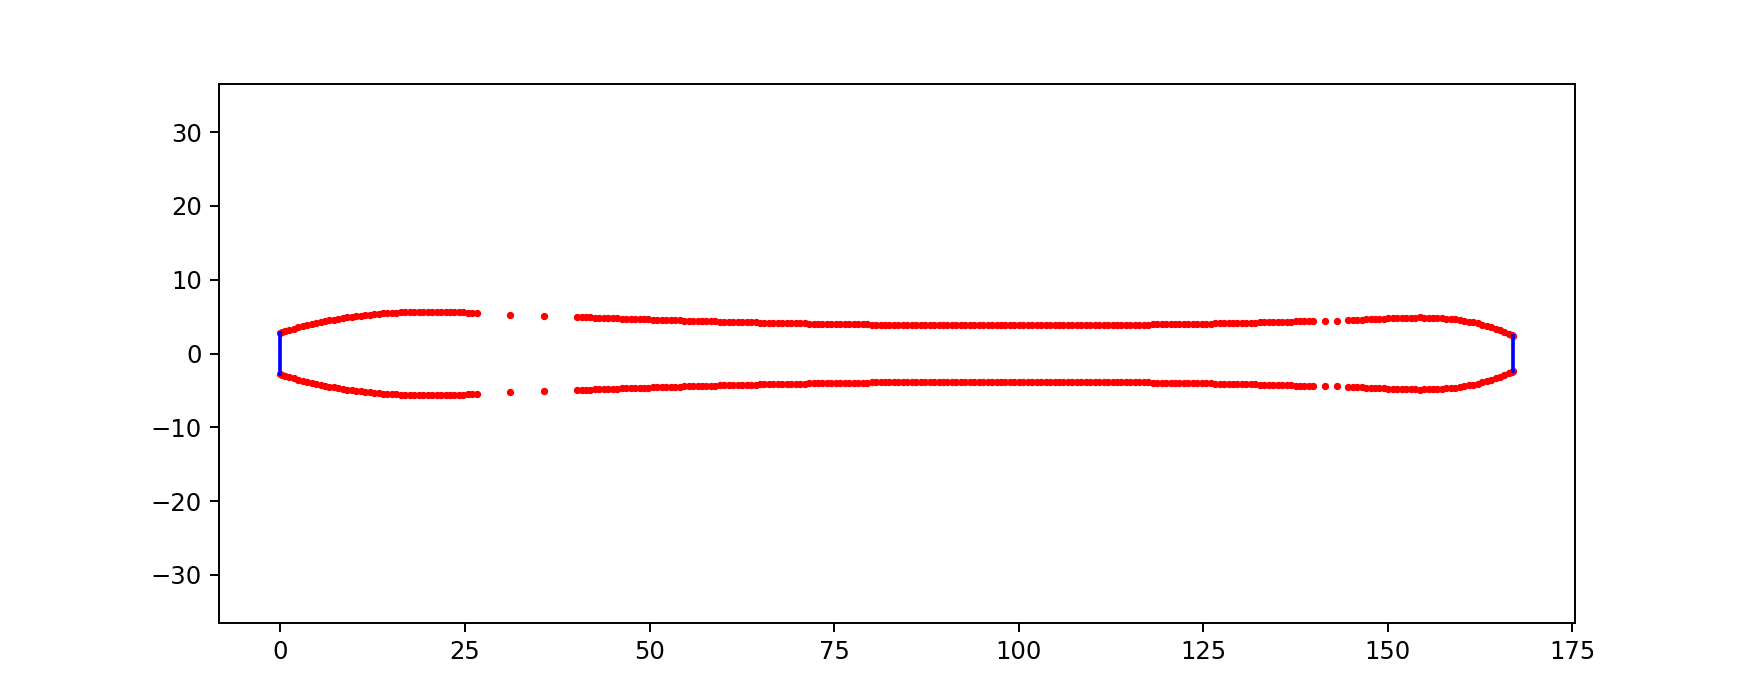

In [448]:
msp = doc.modelspace()
group = groupby(entities=msp, dxfattrib='layer')
group = msp.groupby(dxfattrib='layer')

plt.figure(figsize=(10, 4))

for spline in msp.query('SPLINE[layer=="2_Ski" | layer=="3_SKI" | layer=="0" | layer== "Ski"]'):
    
    fitpoints = spline.fit_points.__str__() 
    controlpoints = spline.control_points.__str__() 
    knots = spline.knots.__str__() 
    weights = spline.weights.__str__() 
   
    plt.plot(np.array(spline.control_points)[:,0],np.array(spline.control_points)[:,1], 'ro', markersize = 2)

for arc in msp.query('ARC[layer=="2_Ski" | layer=="3_SKI" | layer=="0" | layer== "Ski"]'):
    spline = arc.to_spline()
    plt.plot(np.array(spline.control_points)[:,0],np.array(spline.control_points)[:,1], 'ro', markersize = 2)
        
for line in msp.query('LINE[layer=="2_Ski" | layer=="3_SKI" | layer=="0" | layer== "Ski"]'):
    plt.plot([np.array(line.dxf.start)[0],np.array(line.dxf.end)[0]],[np.array(line.dxf.start)[1],np.array(line.dxf.end)[1]],'b-')

plt.axis('equal')
plt.show()

7.599914611069778
11.301130426203772


<IPython.core.display.Javascript object>


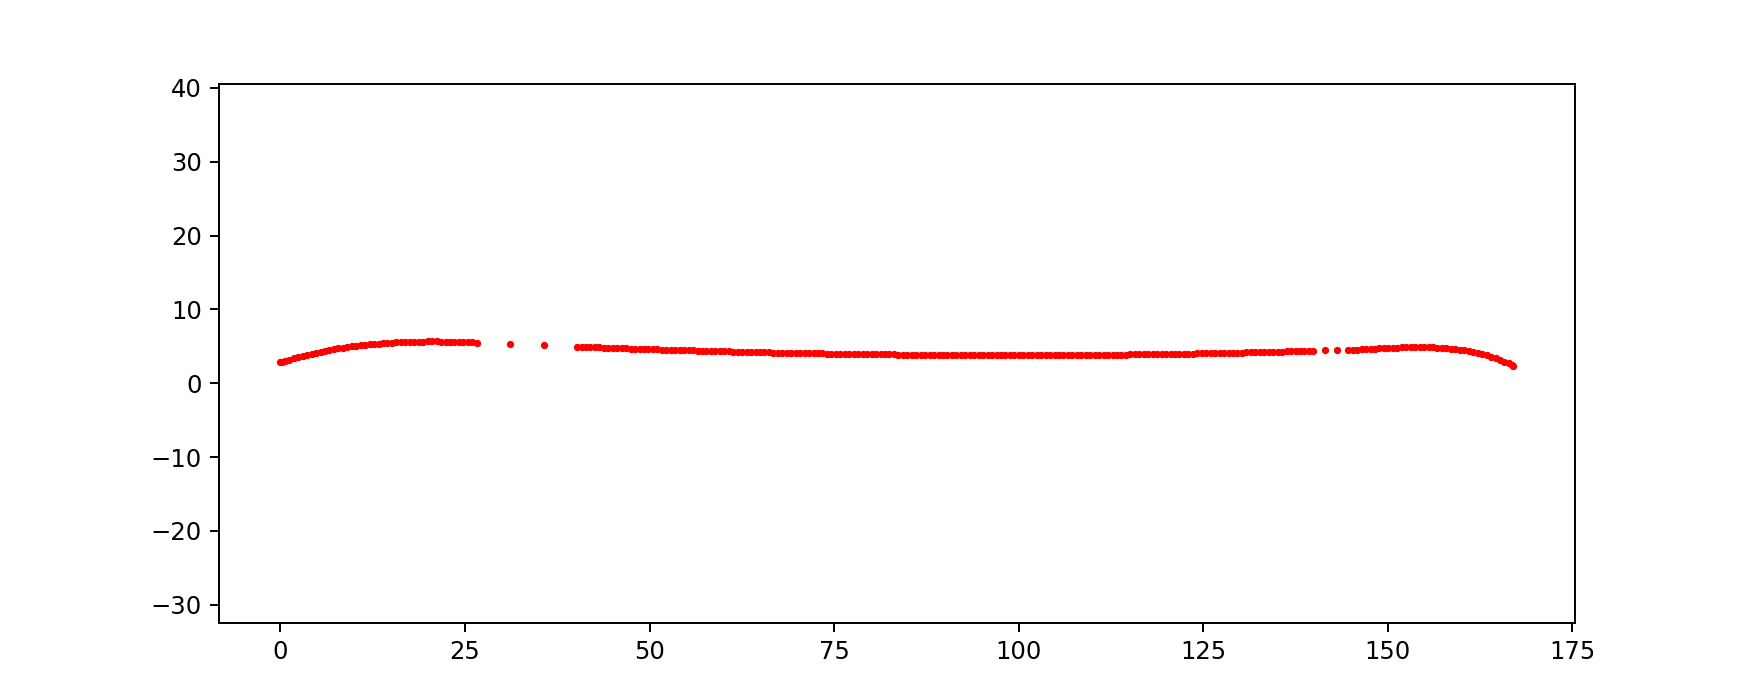

In [449]:
def shift_data(x_points, minimum):
    
    out = x_points - minimum
    
    return out

tot_x = []
tot_y = []
for spline in msp.query('SPLINE[layer=="2_Ski" | layer=="3_SKI" | layer=="0"| layer=="Ski"]'):
    points = np.array(spline.control_points)
    x_nodes = points[:,0] 
   # x_nodes = shift_data(x_nodes_RAW, minimum)
    y_nodes = points[:,1]
    
    if x_nodes[0] > x_nodes[1]:
        x_nodes = x_nodes[::-1]
        y_nodes = y_nodes[::-1]
        
    if y_nodes[1]> 0:
        tot_x = np.append(tot_x,x_nodes)
        tot_y = np.append(tot_y,y_nodes)

#tot_x = shift_data(tot_x, np.amin(tot_x))

nominal_min_width = np.amin(tot_y[50:-50])
print(nominal_min_width*2)
pos_nominal_min_width = tot_x[50+np.argmin(tot_y[50:-50])]
nominal_max_width = np.amax(tot_y)
print(nominal_max_width*2)
pos_nominal_max_width = tot_x[np.argmax(tot_y)]

# Flip data if needed

#tot_x = tot_x - np.amax(tot_x)
#tot_x = -tot_x

#tot_x = (np.flip(tot_x))/10
#tot_y = (np.flip(tot_y))/10

#Interpolate data to fill in the gaps
start_spline = 0.12*(np.amax(tot_x))
end_spline = 0.97*(np.amax(tot_x))
x_spline = tot_x[(tot_x>start_spline) & (tot_x<end_spline)]
y_spline = tot_y[(tot_x>start_spline) & (tot_x<end_spline)]
dx = 0.5
myspline = scipy.interpolate.UnivariateSpline(x_spline, y_spline)
x_myspline = np.arange(x_spline[0], x_spline[-1], dx)
y_myspline = myspline(x_myspline)

plt.figure(figsize=(10, 4))
plt.plot(tot_x,tot_y, 'ro', markersize = 2)
plt.axis('equal')
plt.show()  

In [450]:
 # Choose the right tip and tail
ski_width = nominal_max_width*2*10#mm
print(ski_width)
if ski_width<114:
    tip_file = '\PTB-Roll090'
    tail_file = '\STS-60'
elif ski_width<115:
    tip_file = '\PTB-Roll100'
    tail_file = '\STS-60'
elif ski_width<125 & ski_width>115:
    tip_file = '\PTB-Roll110'
    tail_file = '\STS-70'
elif ski_width<135 & ski_width>125:
    tip_file = '\PTB-Roll120'
    tail_file = '\STS-70'
elif ski_width<145 & ski_width>135:
    tip_file = '\PTB-Roll130'
    tail_file = '\STS-80'
elif ski_width<155 & ski_width>145:
    tip_file = '\PTB-Roll140'
    tail_file = '\STS-90'
elif ski_width<200 & ski_width>155:
    tip_file = '\PTB-Roll145'
    tail_file = '\STS-90'
path = r"C:\Users\Administrator\arduino ski scanner\ski scanner\skiScanner-DataLogger\Post processing\Automatic skin cutting"
tip_dxf = r"C:\Users\Administrator\arduino ski scanner\ski scanner\skiScanner-DataLogger\Post processing\Automatic skin cutting" + tip_file + '.dxf'
tail_dxf = r"C:\Users\Administrator\arduino ski scanner\ski scanner\skiScanner-DataLogger\Post processing\Automatic skin cutting" + tail_file + '.dxf'
print(tip_dxf)
print(tail_dxf)

113.01130426203771
C:\Users\Administrator\arduino ski scanner\ski scanner\skiScanner-DataLogger\Post processing\Automatic skin cutting\PTB-Roll090.dxf
C:\Users\Administrator\arduino ski scanner\ski scanner\skiScanner-DataLogger\Post processing\Automatic skin cutting\STS-60.dxf


## Tail
Loading and plot tail of the skin

<IPython.core.display.Javascript object>


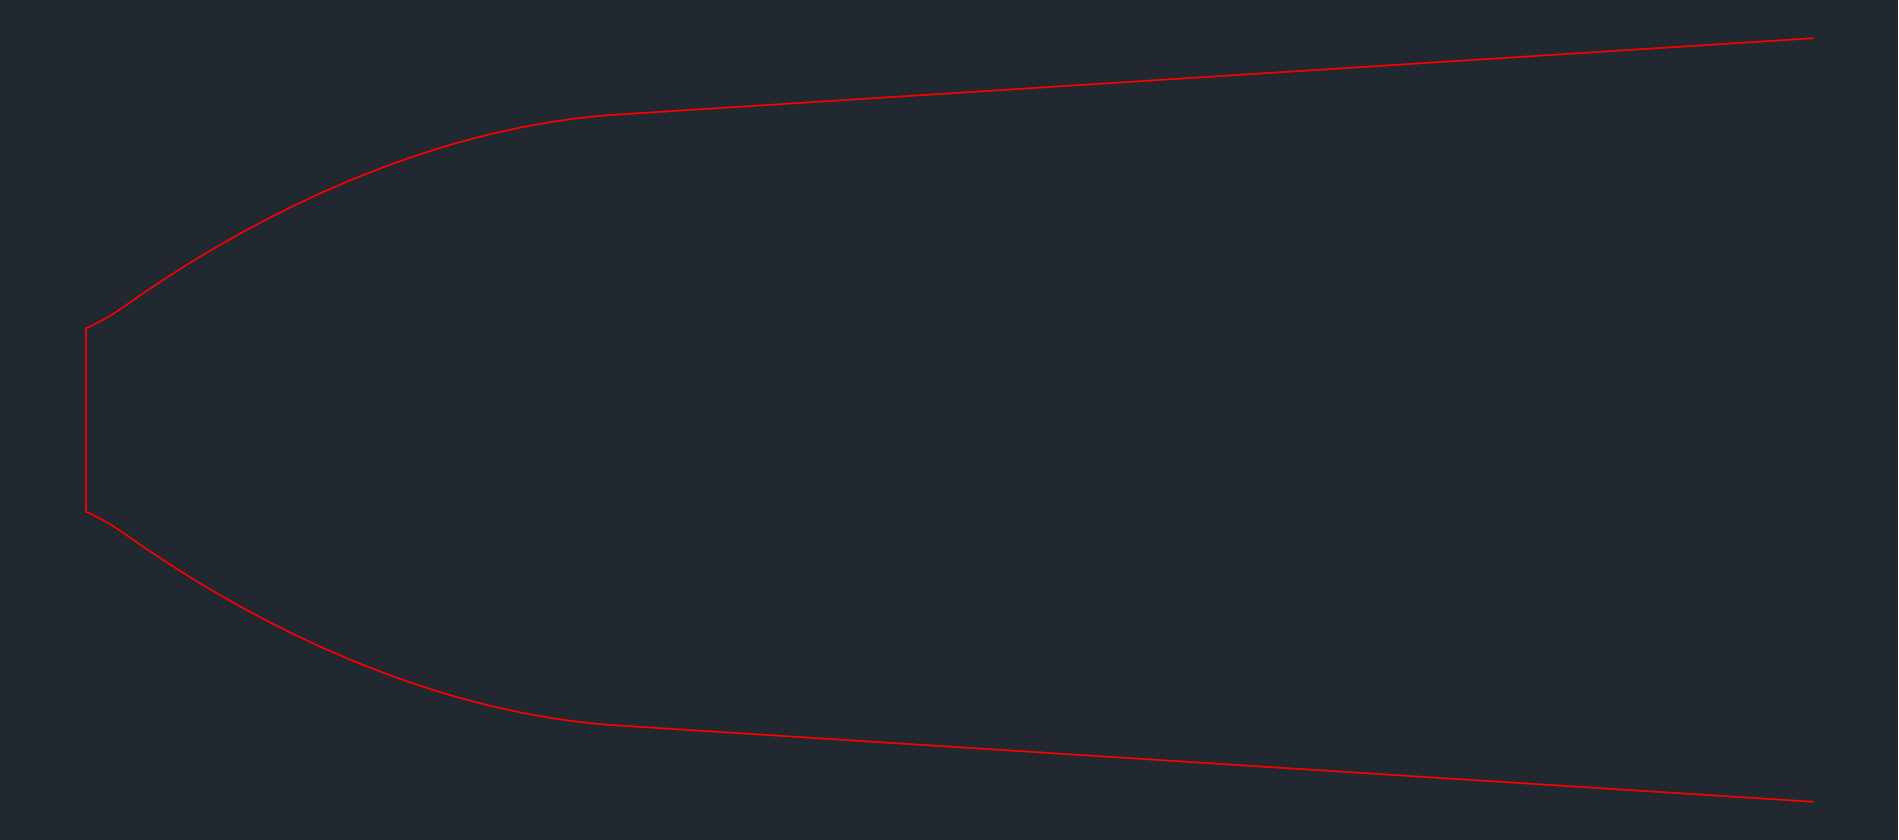

In [451]:
# Safe loading procedure of dxf file(requires ezdxf v0.14):
# The auditor.errors attribute stores severe errors,
# which may raise exceptions when rendering.

try:
    doc_tail, auditor_tail = recover.readfile(tail_dxf)
except IOError:
    print(f'Not a DXF file or a generic I/O error.')
    sys.exit(1)
except ezdxf.DXFStructureError:
    print(f'Invalid or corrupted DXF file.')
    sys.exit(2)

# Printing the dxf content
if not auditor.has_errors:
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ctx = RenderContext(doc_tail)
    out = MatplotlibBackend(ax)
    Frontend(ctx, out).draw_layout(doc_tail.modelspace(), finalize=True)
    # Saving dxf content in png image
    #fig.savefig('your.png', dpi=300)
    

View the content of the tail dxf

In [452]:
msp_tail = doc_tail.modelspace()
group = msp_tail.groupby(dxfattrib='layer')

for layer, entities in group.items():
    print(f'Layer "{layer}" contains following entities:')
    for entity in entities:
        print('    {}'.format(str(entity)))

Layer "0_PEAU" contains following entities:
    SPLINE(#48F4)
    POLYLINE(#48F5)
    POLYLINE(#48F9)
    SPLINE(#48FE)
    SPLINE(#48FF)
    POLYLINE(#4900)
    POLYLINE(#4904)
    SPLINE(#4909)
    LINE(#490A)
    LINE(#496F)
    LINE(#4973)


Saving splines, polylines and lines points

<IPython.core.display.Javascript object>


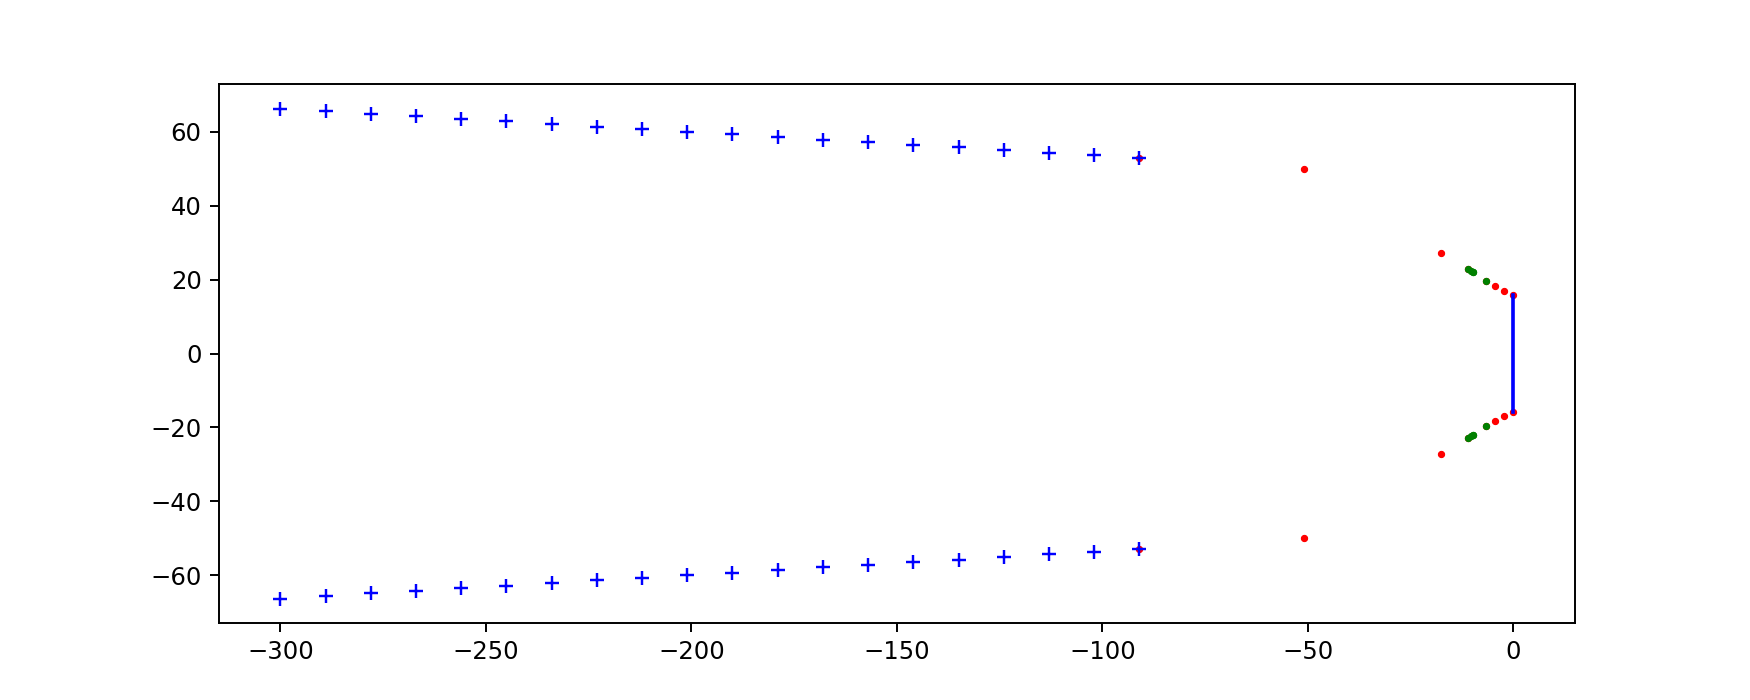

[<class 'ezdxf.entities.polyline.DXFVertex'> VERTEX(#48F6)
 <class 'ezdxf.entities.polyline.DXFVertex'> VERTEX(#48F7)]
[<class 'ezdxf.entities.polyline.DXFVertex'> VERTEX(#48FA)
 <class 'ezdxf.entities.polyline.DXFVertex'> VERTEX(#48FB)
 <class 'ezdxf.entities.polyline.DXFVertex'> VERTEX(#48FC)]
[<class 'ezdxf.entities.polyline.DXFVertex'> VERTEX(#4901)
 <class 'ezdxf.entities.polyline.DXFVertex'> VERTEX(#4902)]
[<class 'ezdxf.entities.polyline.DXFVertex'> VERTEX(#4905)
 <class 'ezdxf.entities.polyline.DXFVertex'> VERTEX(#4906)
 <class 'ezdxf.entities.polyline.DXFVertex'> VERTEX(#4907)]


In [453]:
threshold = 10 #mm

plt.figure(figsize=(10, 4))
#Save and plot all spline points of the tail
lines_points_tail_start = list()
lines_points_tail_end = list()
lines_point_tail_intersect = list()
splines_points_tail = list()
for spline in msp_tail.query('SPLINE[layer=="0_PEAU"]'):
    
    fitpoints = spline.fit_points.__str__() 
    controlpoints = spline.control_points.__str__() 
    knots = spline.knots.__str__() 
    weights = spline.weights.__str__() 
    if np.array(spline.control_points)[0,1] >= 0:
        copy = np.array(spline.control_points)
        copy[:,0] = -copy[:,0]
        lines_point_tail_intersect.append((np.take(copy,[0,1],axis=1)))
    plt.plot(-(np.array(spline.control_points)[:,0]),np.array(spline.control_points)[:,1], 'ro', markersize = 2)

#Save and plot all polyline points of the tail
polyline_points_tail = list()
for polyline in msp_tail.query('POLYLINE[layer=="0_PEAU"]'):
    
    polyline_points = polyline.vertices[:]
   
    polyline_points = np.array(polyline_points)
    print(polyline_points)
    for point in polyline_points:
        newpoint = point.format(format='xy') 
        if newpoint[1] >= 0:
            polyline_points_tail.append((np.reshape(newpoint,(1,2))))
        #print('polyline_points_tail')
        #print(polyline_points_tail)
        plt.plot(-newpoint[0], newpoint[1], 'go', markersize = 2)
polyline_points_tail_formatted = np.concatenate(polyline_points_tail,axis=0)
polyline_points_tail_formatted = polyline_points_tail_formatted[np.argsort(polyline_points_tail_formatted[:, 0])]
polyline_points_tail_formatted[:,0] = -polyline_points_tail_formatted[:,0]

#Save and plot all the lines of the tail

for line in msp_tail.query('LINE[layer=="0_PEAU"]'):
    #print(-np.array(line.dxf.end)[0])
    if (abs(-np.array(line.dxf.end)[0]) >= threshold):
        p = np.polyfit([-(np.array(line.dxf.start)[0]),-(np.array(line.dxf.end)[0])],[(np.array(line.dxf.start)[1]),(np.array(line.dxf.end)[1])],1)
        x = np.linspace(-np.array(line.dxf.start)[0],-np.array(line.dxf.end)[0],20)
        y = np.polyval(p,x)
        plt.plot(x,y,'b+')
        if y[1] >= 0:
            lines_point_tail_intersect.append(np.transpose(np.vstack((x,y))))
        
    else:
        plt.plot([-(np.array(line.dxf.start)[0]),-(np.array(line.dxf.end)[0])],[(np.array(line.dxf.start)[1]),(np.array(line.dxf.end)[1])],'b-')


        #if np.array(line.dxf.start)[0] < max_splines_tail:

        lines_points_tail_start.append(np.take(np.array(line.dxf.start),[0,1],axis=0))

        lines_points_tail_end.append(np.take(np.array(line.dxf.end),[0,1],axis=0))
        
points_2intersect = np.concatenate(lines_point_tail_intersect, axis = 0)
points_2intersect = np.append(points_2intersect,polyline_points_tail_formatted, axis=0)
points_2intersect = points_2intersect[np.argsort(points_2intersect[:, 0])]
points_2intersect = np.unique(points_2intersect, axis=0)

## Tip
Loading and plot tip of the skin

<IPython.core.display.Javascript object>


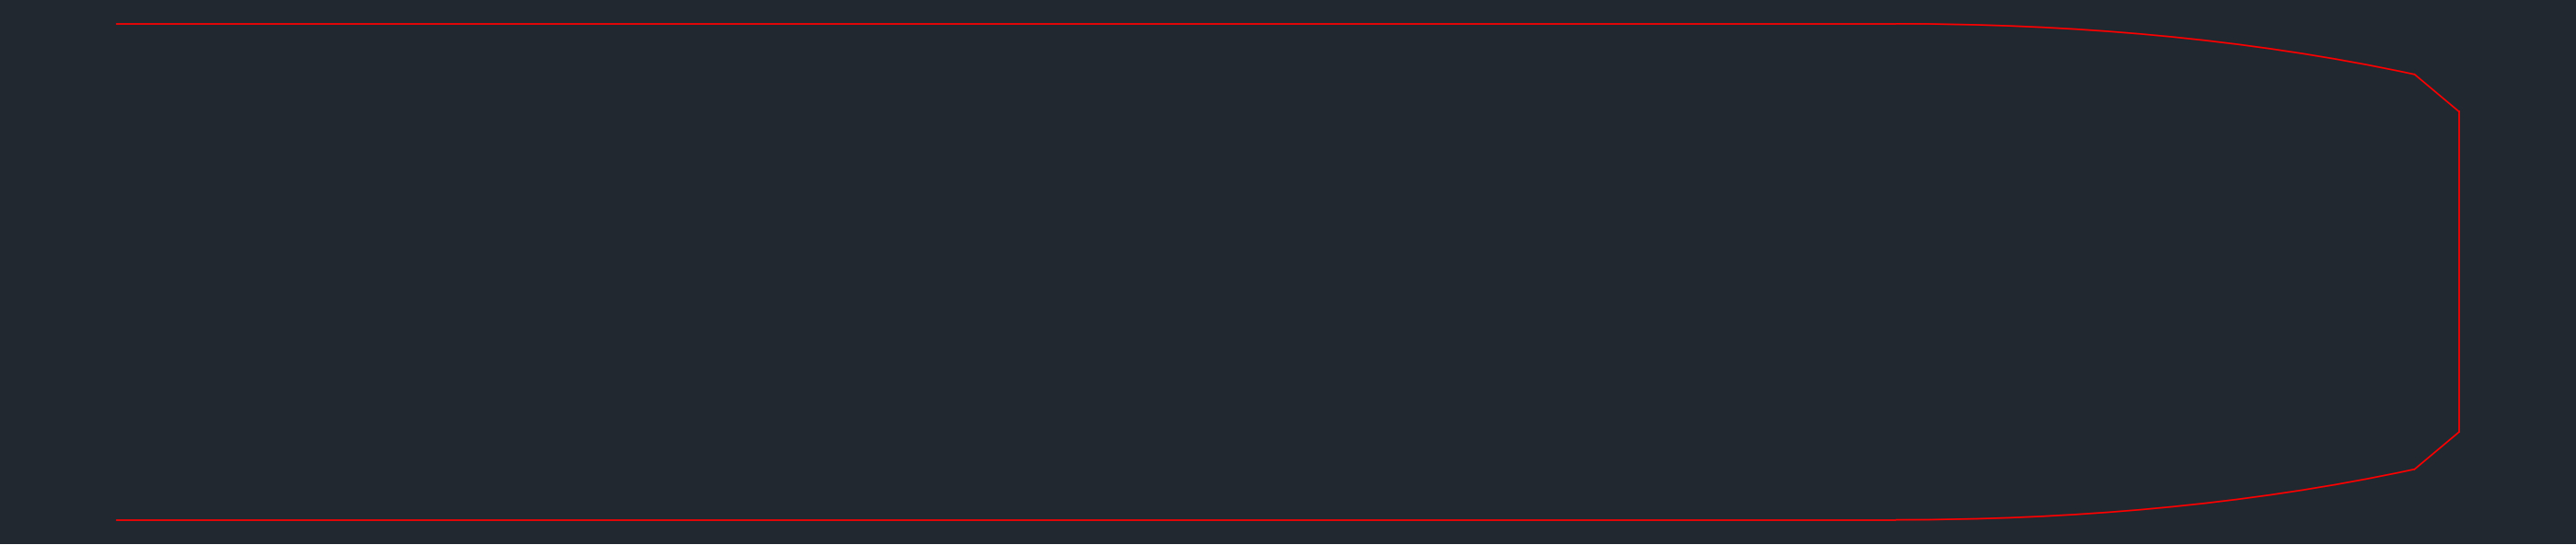

In [454]:
# Safe loading procedure of dxf file(requires ezdxf v0.14):
# The auditor.errors attribute stores severe errors,
# which may raise exceptions when rendering.

try:
    doc_tip, auditor_tip = recover.readfile(tip_dxf)
except IOError:
    print(f'Not a DXF file or a generic I/O error.')
    sys.exit(1)
except ezdxf.DXFStructureError:
    print(f'Invalid or corrupted DXF file.')
    sys.exit(2)

# Printing the dxf content
if not auditor.has_errors:
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ctx = RenderContext(doc_tip)
    out = MatplotlibBackend(ax)
    Frontend(ctx, out).draw_layout(doc_tip.modelspace(), finalize=True)
    # Saving dxf content in png image
    #fig.savefig('your.png', dpi=300)

View the content of the tip dxf

In [455]:
msp_tip = doc_tip.modelspace()
group = msp_tip.groupby(dxfattrib='layer')

for layer, entities in group.items():
    print(f'Layer "{layer}" contains following entities:')
    for entity in entities:
        print('    {}'.format(str(entity)))

Layer "0_PEAU" contains following entities:
    LINE(#494A)
    LINE(#494B)
    LINE(#494C)
    LINE(#4A36)
    SPLINE(#4A38)
    SPLINE(#4A39)
    LINE(#4A3A)


Saving splines, polylines and lines points

<IPython.core.display.Javascript object>


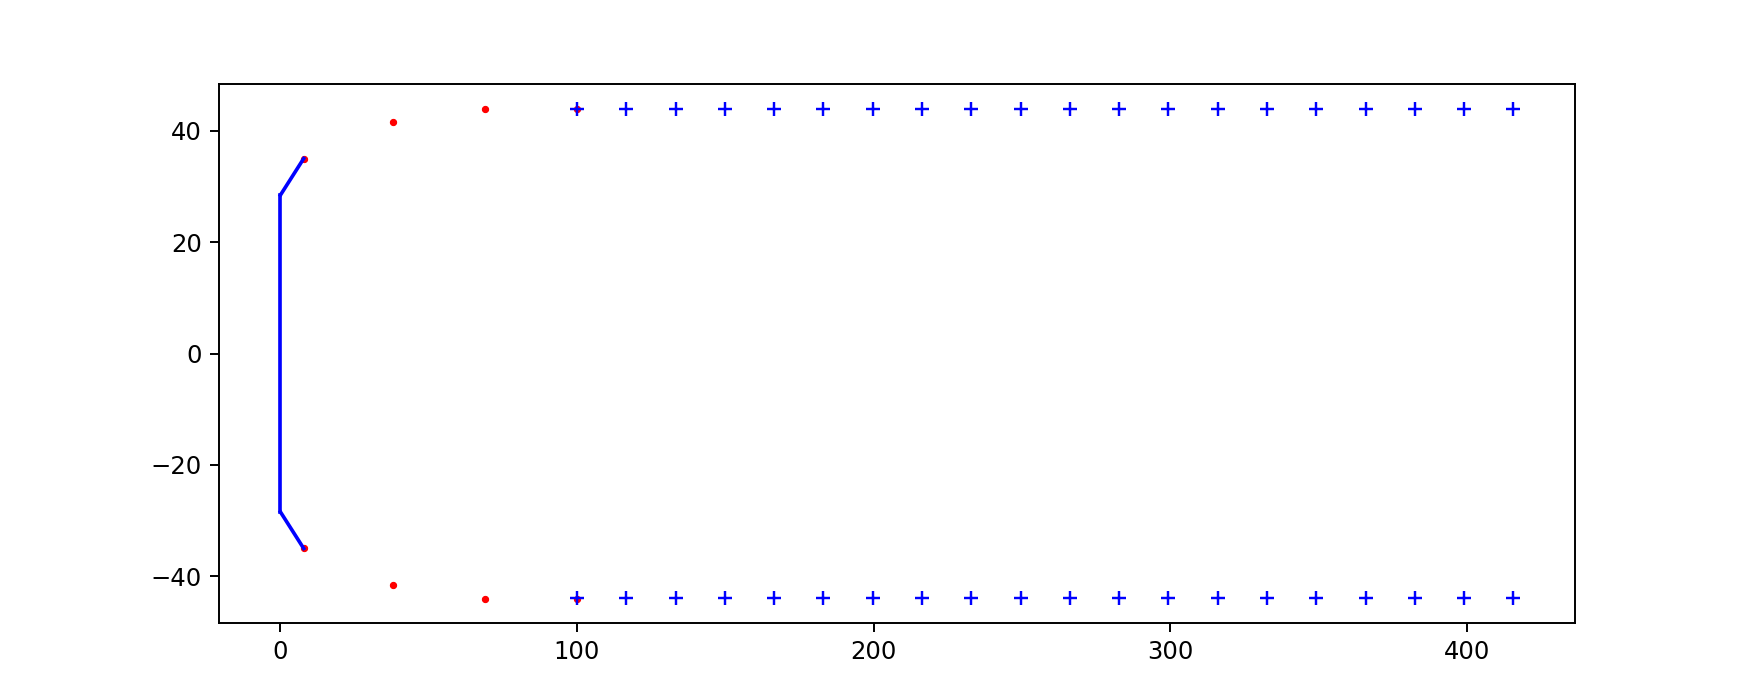

In [456]:
threshold = 10 #mm

plt.figure(figsize=(10, 4))
#Save and plot all spline points of the tip
splines_points_tip = list()
for spline in msp_tip.query('SPLINE[layer=="0_PEAU"]'):
    
    fitpoints = spline.fit_points.__str__() 
    controlpoints = spline.control_points.__str__() 
    knots = spline.knots.__str__() 
    weights = spline.weights.__str__() 
    if np.array(spline.control_points)[0,1] >= 0:
        splines_points_tip.append((np.take(np.array(spline.control_points),[0,1],axis=1)))
        #print('splines_points_tip')
        #print(splines_points_tip)
    
    plt.plot(-(np.array(spline.control_points)[:,0]),np.array(spline.control_points)[:,1], 'ro', markersize = 2)

#Save and plot all polyline points of the tip
polyline_points_tip = list()
for polyline in msp_tip.query('POLYLINE[layer=="0_PEAU"]'):
    
    polyline_points = polyline.vertices[:]
   
    polyline_points = np.array(polyline_points)
    
    for point in polyline_points:
        newpoint = point.format(format='xy') 
        if newpoint[1] >= 0:
            polyline_points_tip.append((np.reshape(newpoint,(1,2))))
        print('polyline_points_tip')
        print(polyline_points_tip)
        plt.plot(-newpoint[0], newpoint[1], 'go', markersize = 2)

#Save and plot all the lines of the tip
lines_points_tip_start = list()
lines_points_tip_end = list()
lines_point_tip_intersect = list()
for line in msp_tip.query('LINE[layer=="0_PEAU"]'):
    #print(-np.array(line.dxf.end)[0])
    if (-np.array(line.dxf.end)[0] >= threshold):
        p = np.polyfit([-(np.array(line.dxf.start)[0]),-(np.array(line.dxf.end)[0])],[(np.array(line.dxf.start)[1]),(np.array(line.dxf.end)[1])],1)
        x = np.linspace(-np.array(line.dxf.start)[0],-np.array(line.dxf.end)[0],20)
        y = np.polyval(p,x)
        plt.plot(x,y,'b+')
        lines_point_tip_intersect.append(np.vstack((x,y)))
    else:
        plt.plot([-(np.array(line.dxf.start)[0]),-(np.array(line.dxf.end)[0])],[(np.array(line.dxf.start)[1]),(np.array(line.dxf.end)[1])],'b-')


        #if np.array(line.dxf.start)[0] < max_splines_tail:

        lines_points_tip_start.append(np.take(np.array(line.dxf.start),[0,1],axis=0))

        lines_points_tip_end.append(np.take(np.array(line.dxf.end),[0,1],axis=0))
   # print('Line start x and y')
   # print(-np.array(line.dxf.start)[0])
   # print(np.array(line.dxf.start)[1])
    #print('Line end x and y')
    #print(-np.array(line.dxf.end)[0])
    #print(np.array(line.dxf.end)[1])

#print('lines_points_tip')
#print(lines_points_tip)
#print('lines_point_tip_intersect')
#print(lines_point_tip_intersect)

plt.figure(figsize=(10, 4))
splines_points = list()
for spline in msp_tip.query('SPLINE[layer=="0_PEAU"]'):
    
    fitpoints = spline.fit_points.__str__() 
    controlpoints = spline.control_points.__str__() 
    knots = spline.knots.__str__() 
    weights = spline.weights.__str__() 
    x = -(np.array(spline.control_points)[:,0])
    print('x')
    print(x)
    y = np.array(spline.control_points)[:,1]
    print('y')
    print(y)
    
    if not(y.any() <= 0):
        splines_points.append(np.stack((np.transpose(x), np.transpose(y)))/10)
        print('splines_points')
        print(splines_points)
 
    plt.plot(-(np.array(spline.control_points)[:,0]),np.array(spline.control_points)[:,1], 'ro', markersize = 2)
    
lines_points = np.empty((5,2,2))
print(lines_points)
i = 0
for line in msp_tip.query('LINE[layer=="0_PEAU"]'):
    x = [-(np.array(line.dxf.start)[0]),-(np.array(line.dxf.end)[0])]
    y = [np.array(line.dxf.start)[1],np.array(line.dxf.end)[1]]
    lines_points[i,:,:] = (np.stack((np.transpose(x), np.transpose(y))))/10
    i = i+1 
    print(lines_points)
    plt.plot([-(np.array(line.dxf.start)[0]),-(np.array(line.dxf.end)[0])],[np.array(line.dxf.start)[1],np.array(line.dxf.end)[1]],'b-')
    

Plot ski profile from dxf

## This is not required maybe for scanner data (to be fixed!!)

<class 'numpy.ndarray'>


<IPython.core.display.Javascript object>


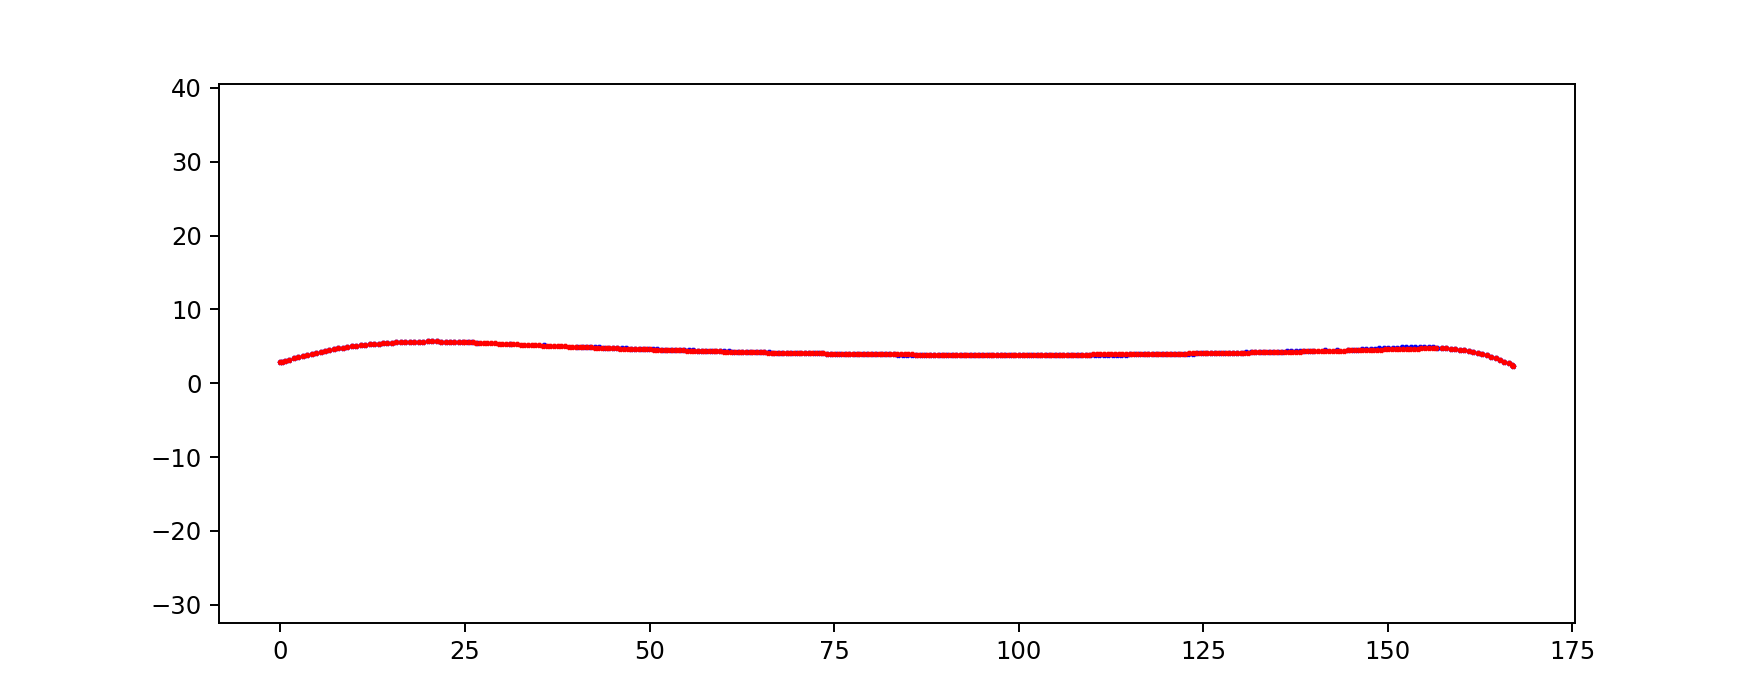

In [457]:
#Merge the original starting point and the ones from the interpolation
x_myspline_final = np.concatenate((tot_x[(tot_x<=(start_spline+5))], x_myspline[(x_myspline>(start_spline+5))&(x_myspline<(end_spline-5))], tot_x[(tot_x>=(end_spline-5))]))
y_myspline_final = np.concatenate((tot_y[(tot_x<=(start_spline+5))], y_myspline[(x_myspline>(start_spline+5))&(x_myspline<(end_spline-5))], tot_y[(tot_x>=(end_spline-5))]))
#y_myspline = np.concatenate((tot_y[(tot_x<=start_spline)], y_myspline, tot_y[(tot_x>=end_spline)]))

sectionA = np.vstack([x_myspline_final,y_myspline_final]).T
sectionA = sectionA[np.argsort(sectionA[:, 0])] #Sort the array
sectionA = np.unique(sectionA, axis=0) #Remove duplicates so to have no zero division error in add_spline
sectionB = np.copy(sectionA)
sectionB[:,1] = -sectionB[:,1]
#print(sectionA)
print(type(sectionA))

plt.figure(figsize=(10, 4))
plt.plot(tot_x, tot_y, 'b*', markersize = 2)
plt.plot(sectionA[:,0], sectionA[:,1], 'r*', markersize = 2)
#plt.plot(pos_nominal_min_width,nominal_min_width, 'go', markersize=4)
#plt.plot(pos_nominal_max_width,nominal_max_width, 'go', markersize=4)
plt.axis('equal')
plt.show()

# Skin profile computation
In this section we compute the skin profile with a 0.17 cm offset from the side of the ski and merging the tip and tail shapes from the ones chosen previously

In [458]:
#Setting parameters for skin drawing 

dist_from_tail = 6 #cm
dist_from_tip = 6 #cm
dist_from_side = 0.17 #cm
#dist_from_side_tip = 0.9 #cm this is the max distance from the side of the ski in the tip
#dist_from_side_tail = 0.9 #cm

buckle_half = buckle/2
offset_start_skin = 3.4 #cm
print(buckle_half)
delta = 8 #cm needed to include some points of the ski profile to draw a spline (you need more points than the order of the interpolation)

4.25


Find the right point where the skin should start according to the type ok buckle

In [459]:
sectionA_temp = sectionA[sectionA[:,0]<5]
diff = abs(sectionA_temp[:,1]-buckle_half)
#print(diff)
start_buckle = np.where(sectionA_temp[:,0] == sectionA_temp[np.argmin(diff),0])
start_buckle = start_buckle[0]
print(sectionA[start_buckle,0])
start_skin = sectionA[start_buckle,0]+offset_start_skin
print(start_skin)
diff = abs(sectionA[:,0]-start_skin)

#Print distance form the closest point to the position I computed
print('Error from the required point')
print(np.amin(diff)) #Most probably you have got a difference of around 2 mm to get the closer point in the ski profile
start_skin_idx = np.where(sectionA[:,0] == sectionA[np.argmin(diff),0])
start_skin_idx = start_skin_idx[0]

dist_from_tip = start_skin

[4.83460522]
[8.23460522]
Error from the required point
0.2267412594301348


In [460]:
#Set line to intersect in the right position

lines_point_tip_intersect = np.array(lines_point_tip_intersect)/10
#print(lines_point_tip_intersect)
line_offset = lines_point_tip_intersect[0][0][0] #cm
print(line_offset)

#Set the correct offset to the line to intersect

lines_point_tip_intersect_def = np.vstack((lines_point_tip_intersect[0][0]+dist_from_tip,lines_point_tip_intersect[0][1]))
print(lines_point_tip_intersect_def[0][0])
print(lines_point_tip_intersect_def[1][0])

10.0
18.23460522349452
4.400000000000001


In [461]:
max_length = np.amax(sectionA[:,0])
print(max_length)
skin_profileA = sectionA[(sectionA[:,0] > dist_from_tip+line_offset) & (sectionA[:,0] < max_length-dist_from_tail)]
start_skin_profileA = skin_profileA[0,:]
print(start_skin_profileA)
#start_spline[1] = start_spline[1] - dist_from_side_tip
#skin_profileA = sectionA[(sectionA[:,0] > 0.14*max_length) & (sectionA[:,0] < max_length-dist_from_tail)]

#Subtract from ski profile the side offset
skin_profileA[:,1] = skin_profileA[:,1] - dist_from_side
print(skin_profileA)

167.0
[18.73681542  5.63539433]
[[ 18.73681542   5.46539433]
 [ 19.34124227   5.4740613 ]
 [ 19.94566793   5.47907452]
 [ 20.55009244   5.48056521]
 [ 21.15451586   5.47866459]
 [ 21.75893821   5.47350387]
 [ 22.36335954   5.46521424]
 [ 22.96777989   5.45392701]
 [ 23.57219929   5.43977303]
 [ 24.17661785   5.42288478]
 [ 24.78103538   5.40338873]
 [ 25.05009244   5.40716763]
 [ 25.55009244   5.38216695]
 [ 26.05009244   5.35736426]
 [ 26.55009244   5.33275919]
 [ 27.05009244   5.30835139]
 [ 27.55009244   5.28414051]
 [ 28.05009244   5.26012619]
 [ 28.55009244   5.23630808]
 [ 29.05009244   5.21268583]
 [ 29.55009244   5.18925907]
 [ 30.05009244   5.16602746]
 [ 30.55009244   5.14299065]
 [ 31.05009244   5.12014826]
 [ 31.55009244   5.09749997]
 [ 32.05009244   5.0750454 ]
 [ 32.55009244   5.0527842 ]
 [ 33.05009244   5.03071603]
 [ 33.55009244   5.00884052]
 [ 34.05009244   4.98715732]
 [ 34.55009244   4.96566608]
 [ 35.05009244   4.94436644]
 [ 35.55009244   4.92325805]
 [ 36.05009

## Find intersection tip

In [462]:
#Find the closer point to lines_point_tip_intersect_def[1][0]
diff = abs(skin_profileA[:,1]-lines_point_tip_intersect_def[1][0])
print(lines_point_tip_intersect_def[1][0])
print(diff)
#print(skin_profileA[np.argmin(diff),1])
intersection = np.where(skin_profileA[:,1] == skin_profileA[np.argmin(diff[:round(len(diff)/2)]),1])
intersection = intersection[0][0]
print(intersection)
if intersection<5:
    offset_idx = 5
    intersection = np.where(skin_profileA[:,1] == skin_profileA[np.argmin(diff[offset_idx:]),1])
    intersection = intersection[0][0]+offset_idx
print(intersection)
skin_profileA = skin_profileA[intersection:,:]
print(skin_profileA[0][0])

4.400000000000001
[1.06539433 1.0740613  1.07907452 1.08056521 1.07866459 1.07350387
 1.06521424 1.05392701 1.03977303 1.02288478 1.00338873 1.00716763
 0.98216695 0.95736426 0.93275919 0.90835139 0.88414051 0.86012619
 0.83630808 0.81268583 0.78925907 0.76602746 0.74299065 0.72014826
 0.69749997 0.6750454  0.6527842  0.63071603 0.60884052 0.58715732
 0.56566608 0.54436644 0.52325805 0.50234056 0.4816136  0.46107683
 0.4407299  0.42057244 0.4006041  0.38082453 0.36123338 0.34183028
 0.32261489 0.30358686 0.28474582 0.26609142 0.24762331 0.22934114
 0.21124455 0.19333318 0.17560669 0.15806471 0.14070689 0.12353289
 0.10654233 0.08973488 0.07311018 0.05666786 0.04040759 0.02432899
 0.00843173 0.00728456 0.02282023 0.03817564 0.05335113 0.06834706
 0.0831638  0.09780168 0.11226107 0.12654231 0.14064578 0.15457181
 0.16832076 0.18189299 0.19528885 0.2085087  0.22155288 0.23442176
 0.24711569 0.25963502 0.27198011 0.28415131 0.29614897 0.30797345
 0.31962511 0.33110429 0.34241136 0.35354667

In [463]:
intersected_line_start = [lines_point_tip_intersect_def[0][0],lines_point_tip_intersect_def[1][0]]
intersected_line_end = [skin_profileA[0][0],skin_profileA[0][1]]

## Find intersection tail

In [464]:
max_skin_profileA_x = np.amax(skin_profileA[:,0])

#locate the tail points in the right position
points_2intersect = points_2intersect/10
points_2intersect[:,0] = points_2intersect [:,0]+max_skin_profileA_x
#print(points_2intersect[0,0])

skin_profileA_2intersect = skin_profileA[skin_profileA[:,0]>=points_2intersect[0,0]]
#print(skin_profileA_2intersect)
idx = np.where(points_2intersect[:,1]<np.amax(skin_profileA_2intersect[:,1]))
points_2intersect = points_2intersect[idx,:]
#print(points_2intersect[0])
skin_profileA = skin_profileA[skin_profileA[:,0]<points_2intersect[0,0][0]]
diff = skin_profileA[-1,1]-points_2intersect[0,0][1]
#print(diff)
skin_profileA = skin_profileA[skin_profileA[:,0]<points_2intersect[0,0][0]-(5*diff)]
#IMPORTANT: the tail width must be always smaller than the tip width (tip width sets the roll width)
if(skin_profileA[:round(len(skin_profileA[:,1])/2),1].max()<skin_profileA[round(len(skin_profileA[:,1])/2):,1].max()):
    skin_profileA = skin_profileA[skin_profileA[:,1]<=skin_profileA[:round(len(skin_profileA[:,1])/2),1].max()]
skin_profileA = np.append(skin_profileA[:,:],points_2intersect[0],axis=0)
#print(skin_profileA)

In [465]:
#CHECK THAT THE FIRST ONE IS GREATER THAN THE SECOND ONE
print(skin_profileA[:round(len(skin_profileA[:,1])/2),1].max())
print(skin_profileA[round(len(skin_profileA[:,1])/2):,1].max())

4.392715437283996
4.380958667146176


This section interpolates the tip and tail with 0.9 cm of distance from the ski in the tip and in the tail (not used rn)

In [466]:
#skin_profileA = np.vstack([start_spline,skin_profileA])
#tip = skin_profileA[skin_profileA[:,0] < (0.14*max_length + delta)] #select a set of points for spline interpolation
#yspline = scipy.interpolate.UnivariateSpline(tip[:,0], tip[:,1])
#x = np.arange(tip[0,0], tip[-1,0], dx)
#tip_spline = yspline(x) # generate spline for the tip section
#final_tip = np.vstack([x,tip_spline]).T
#skin_profileA = np.vstack([final_tip,skin_profileA[skin_profileA[:,0] >= (0.14*max_length + delta)]])

#end_spline = skin_profileA[-1,:]
#end_spline[1] = end_spline[1] - (dist_from_side_tail+dist_from_side)
#start_tail = 0.9*(max_length-dist_from_tail)

#tail = skin_profileA[(skin_profileA[:,0]<start_tail) & (skin_profileA[:,0]>(start_tail-delta))]
#tail = np.vstack([tail,end_spline])

#yspline = scipy.interpolate.UnivariateSpline(tail[:,0], tail[:,1])
#x = np.arange(tail[0,0], tail[-1,0], dx)
#tail_spline = yspline(x) # generate spline for the tail section
#final_tail = np.vstack([x,tail_spline]).T

#skin_profileA = np.vstack([skin_profileA[skin_profileA[:,0]<=(start_tail-delta)], final_tail])

Add tip to skin profile

tip_length = np.amax(splines_points[0][0][:]) #keep points from spline to the tip #cm

delta = 10 # it can range from 0 to 30 according to the difference with the width of the ski   #TO BE FIXED

print(tip_length)
print(skin_profileA[:,0].min())
skin_profileA = skin_profileA[skin_profileA[:,0] > skin_profileA[:,0].min()+tip_length+delta]
print(skin_profileA[:,0].min())

tip_x = splines_points[0][0][:]
tip_x = np.flip(tip_x) + dist_from_tip
#tip_x = np.append(tip_x,skin_profileA[0,0])

tip_y = splines_points[0][1][:]
tip_y = np.flip(tip_y)
#tip_y = np.append(tip_y,skin_profileA[0,1])

yspline = scipy.interpolate.UnivariateSpline(tip_x, tip_y)
x = np.arange(tip_x[0], tip_x[-1], dx)
tip_spline = yspline(x) # generate spline for the tip section
final_tip = np.vstack([x,tip_spline]).T

skin_profileA = np.vstack([final_tip,skin_profileA[1:,:]])

plt.figure(figsize=(10, 4))
plt.plot(skin_profileA[:,0], skin_profileA[:,1], 'b*', markersize = 2)
plt.axis('equal')
plt.show()

Add tail to skin profile

tail_length = max_splines_tail/10
#print(tail_length)
dx=0.1
delta = 0 # it can range from 0 to 30 according to the difference with the width of the ski   #TO BE FIXED

skin_profileA = skin_profileA[skin_profileA[:,0] < skin_profileA[:,0].max()-tail_length-delta]
#print(skin_profileA[:,0].argmax())
max_length_tail = skin_profileA[skin_profileA[:,0].argmax(),0]
#print(max_length_tail)
max_width_tail = skin_profileA[skin_profileA[:,0].argmax(),1]
#print(max_width_tail)
splines_points_tail = splines_points_tail[splines_points_tail[:,1] <= max_width_tail]
#print('splines_points_tail')
#print(splines_points_tail)

tail_x = splines_points_tail[:,0]
#print(tail_x)
tail_x = -tail_x + skin_profileA[:,0].max() + tail_length
tail_x = np.flip(tail_x)
#print(tail_x)
#tip_x = np.append(tip_x,skin_profileA[0,0])

tail_y = splines_points_tail[:,1]
#print(tail_y)
tail_y = np.flip(tail_y)
#print(tail_y)
#tip_y = np.append(tip_y,skin_profileA[0,1])

yspline = scipy.interpolate.UnivariateSpline(tail_x, tail_y)
x = np.arange(tail_x[0], tail_x[-1], dx)
tail_spline = yspline(x) # generate spline for the tip section
final_tail = np.vstack([x,tail_spline]).T
print(final_tail)
skin_profileA = np.vstack([skin_profileA[:,:],final_tail])
print(skin_profileA)

Duplicate specular profile

In [467]:
skin_profileA = skin_profileA[np.argsort(skin_profileA[:, 0])] #Sort the array
skin_profileB = np.copy(skin_profileA)
skin_profileB[:,1] = -skin_profileB[:,1] 

In [468]:
## Plot to check the dxf generation

<IPython.core.display.Javascript object>


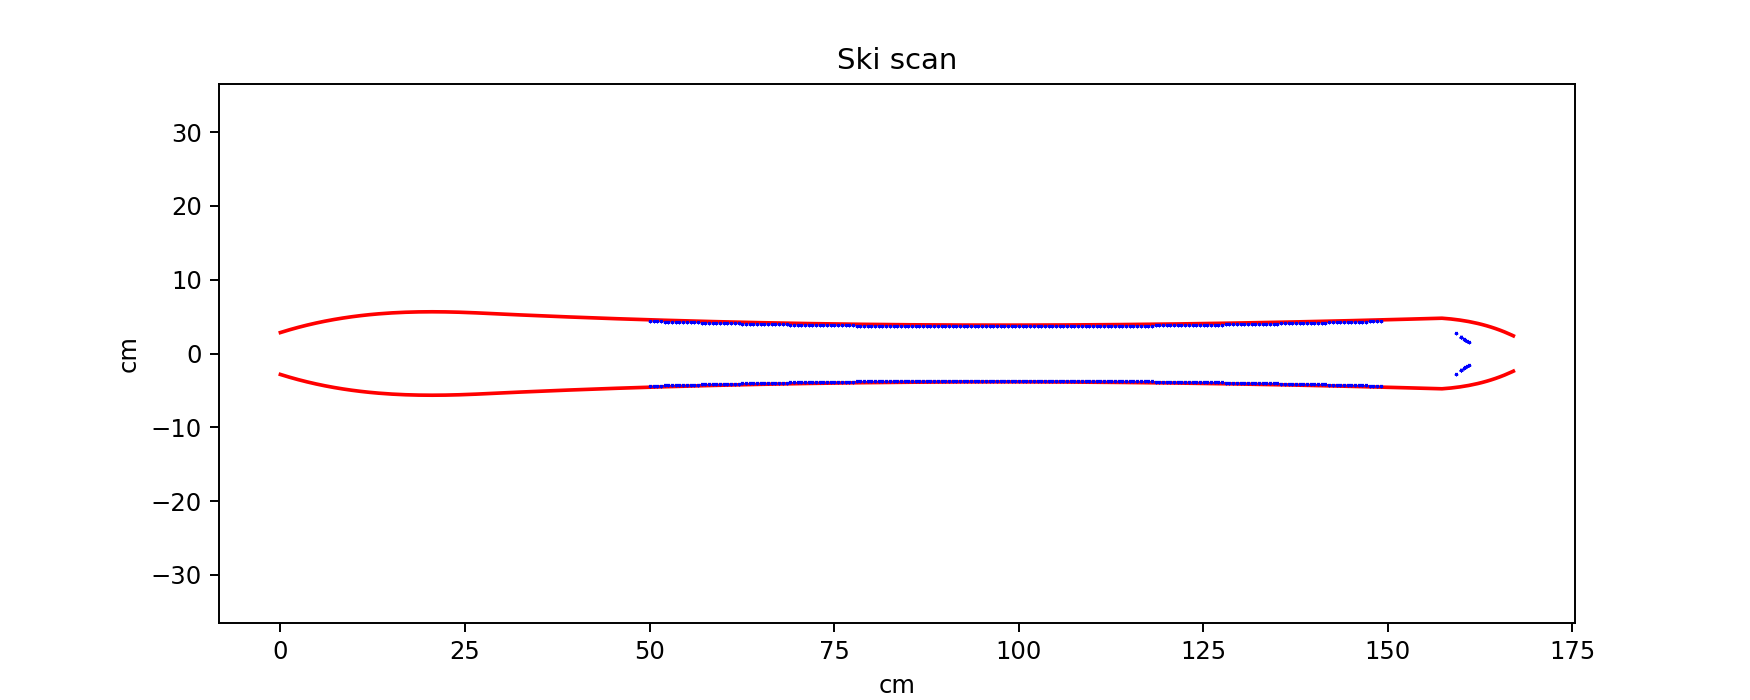

In [469]:
fig1 = plt.figure(figsize=(10, 4))

plt.plot(sectionA[:,0], sectionA[:,1], 'r-', markersize = 2)
plt.plot(sectionA[:,0], -sectionA[:,1], 'r-', markersize = 2)
#plt.plot(skin_profileA_spline[:,0], skin_profileA_spline[:,1], 'b*', markersize = 1)
#plt.plot(skin_profileB_spline[:,0], skin_profileB_spline[:,1], 'b*', markersize = 1)
plt.plot(skin_profileA[:,0], skin_profileA[:,1], 'b*', markersize = 1)
plt.plot(skin_profileB[:,0], skin_profileB[:,1], 'b*', markersize = 1)

#for spline in splines_points_tip:
#    np.transpose(spline)
#    spline = spline/10
#    spline[:,0] = -spline[:,0]+dist_from_tip
#    plt.plot(spline[:,0],spline[:,1],'r*',markersize = 1)
#    plt.plot(spline[:,0],-spline[:,1],'r*',markersize = 1)
    #print(spline)

#for index, line_start in enumerate(lines_points_tip_start):
#    line_start = line_start/10
#    lines_points_tip_end[index] = lines_points_tip_end[index]/10
#    line_start[0] = -line_start[0]+dist_from_tip
#    lines_points_tip_end[index][0] = -lines_points_tip_end[index][0]+dist_from_tip
#    plt.plot([line_start[0],lines_points_tip_end[index][0]] ,[line_start[1],lines_points_tip_end[index][1]],'r-',markersize = 1)
#    print(line_start)
#    print(lines_points_tip_end[index])
    

    

#plt.plot(-(np.array(spline.control_points)[:,0]),np.array(spline.control_points)[:,1], 'ro', markersize = 2)
#print(lines_points)

plt.title('Ski scan')
plt.axis('equal')
plt.xlabel('cm')
plt.ylabel('cm')
plt.show()

In [470]:
##Add just one single spline with smoothed control points
# Create a new DXF document
doc2 = dxf.new(dxfversion='R2018')
# DXF entities (LINE, TEXT, ...) reside in a layout (like modelspace).
msp2 = doc2.modelspace()

doc2.layers.new(name='Ski')
doc2.layers.new(name='Skin')
msp2.add_cad_spline_control_frame(fit_points = sectionA, dxfattribs={'layer': 'Ski'})
minimum = np.amin(sectionA[40:-40,1])
maximum = np.amax(sectionA[:,0])
maximum_width = np.amax(sectionA[:,1])

msp2.add_cad_spline_control_frame(fit_points = sectionB, dxfattribs={'layer': 'Ski'})

msp2.add_line((sectionA[0,0],sectionA[0,1]), (sectionB[0,0],sectionB[0,1]), dxfattribs={'layer': 'Ski'})
msp2.add_line((sectionA[-1,0],sectionA[-1,1]), (sectionB[-1,0],sectionB[-1,1]), dxfattribs={'layer': 'Ski'})

<class 'ezdxf.entities.line.Line'> LINE(#32)

In [471]:
##Add skin_profile splines
msp2.add_cad_spline_control_frame(fit_points = skin_profileA, dxfattribs={'layer': 'Skin'})
msp2.add_cad_spline_control_frame(fit_points = skin_profileB, dxfattribs={'layer': 'Skin'})
#msp2.add_line((skin_profileA[0,0],skin_profileA[0,1]),(skin_profileB[0,0],skin_profileB[0,1]), dxfattribs={'layer': 'Skin'})
#msp2.add_line((skin_profileA[-1,0],skin_profileA[-1,1]),(skin_profileB[-1,0],skin_profileB[-1,1]), dxfattribs={'layer': 'Skin'})

msp2.add_line(intersected_line_start,intersected_line_end, dxfattribs={'layer': 'Skin'})
msp2.add_line([intersected_line_start[0],-intersected_line_start[1]],[intersected_line_end[0],-intersected_line_end[1]], dxfattribs={'layer': 'Skin'})

<class 'ezdxf.entities.line.Line'> LINE(#36)

Add splines and lines from the tip shape

In [472]:
for spline in splines_points_tip:
    np.transpose(spline)
    spline = spline/10
    spline[:,0] = -spline[:,0]+dist_from_tip
    msp2.add_cad_spline_control_frame(fit_points = spline, dxfattribs={'layer': 'Skin'})
    splineB = np.copy(spline)
    splineB[:,1] = -splineB[:,1] 
    msp2.add_cad_spline_control_frame(fit_points = splineB, dxfattribs={'layer': 'Skin'})
    #print(spline)

for index, line_start in enumerate(lines_points_tip_start):
    line_start = line_start/10
    lines_points_tip_end[index] = lines_points_tip_end[index]/10
    line_start[0] = -line_start[0]+dist_from_tip
    lines_points_tip_end[index][0] = -lines_points_tip_end[index][0]+dist_from_tip
    msp2.add_line(line_start,lines_points_tip_end[index], dxfattribs={'layer': 'Skin'})

Add splines, polylines and lines from the tail shape

In [473]:
for index, line_start in enumerate(lines_points_tail_start):
    print(line_start)
    line_start = line_start/10
    lines_points_tail_end[index] = lines_points_tail_end[index]/10
    line_start[0] = line_start[0]+max_skin_profileA_x
    lines_points_tail_end[index][0] = lines_points_tail_end[index][0]+max_skin_profileA_x
    msp2.add_line(line_start,lines_points_tail_end[index], dxfattribs={'layer': 'Skin'})

[ 0.         15.95819631]


In [474]:
# Save DXF document.
doc2.saveas(dxf_filename)

<IPython.core.display.Javascript object>


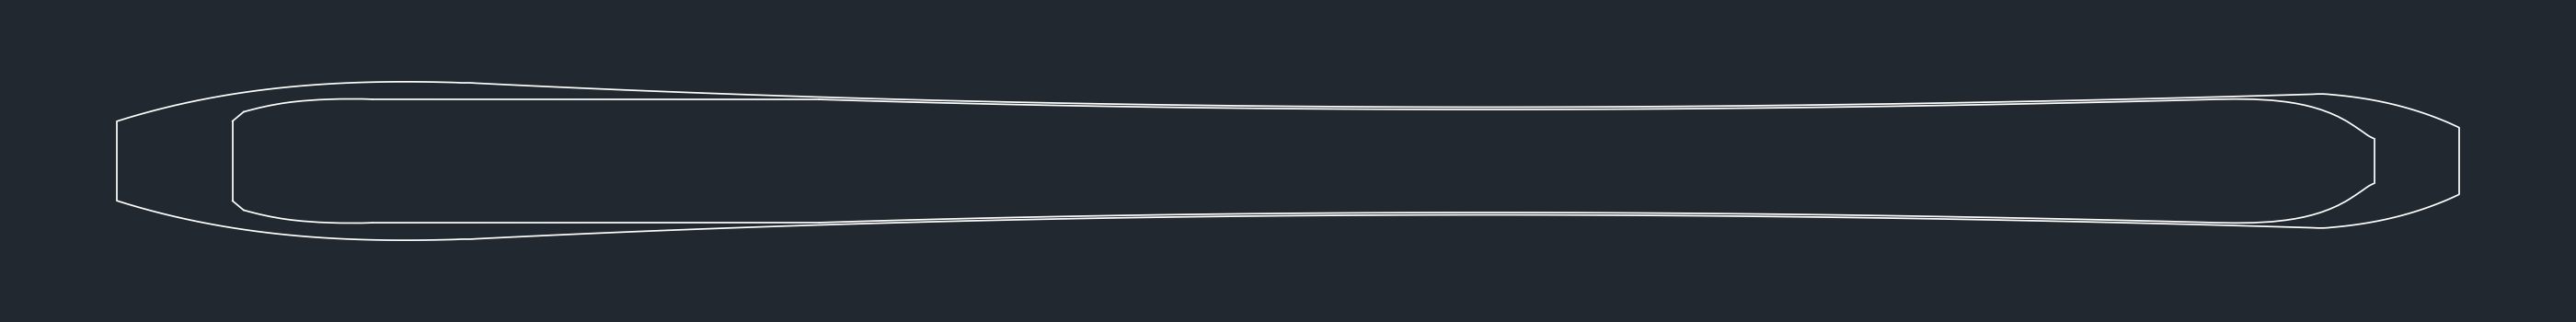

In [475]:
# Safe loading procedure of dxf file(requires ezdxf v0.14):
# The auditor.errors attribute stores severe errors,
# which may raise exceptions when rendering.
try:
    doc, auditor = recover.readfile(dxf_filename)
except IOError:
    print(f'Not a DXF file or a generic I/O error.')
    sys.exit(1)
except ezdxf.DXFStructureError:
    print(f'Invalid or corrupted DXF file.')
    sys.exit(2)

# Printing the dxf content
if not auditor.has_errors:
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_axes([0, 0, 1, 1])
    ctx = RenderContext(doc)
    out = MatplotlibBackend(ax)
    Frontend(ctx, out).draw_layout(doc.modelspace(), finalize=True)
    # Saving dxf content in png image
    #fig.savefig('your.png', dpi=300)